In [25]:
from pandas import DataFrame, read_csv, to_numeric
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from bigml.api import BigML
import kaggle

%matplotlib inline

In [17]:
compression = True  #Do we compress the csv files?

version='v1.3'

big_ml_project = 'project/5d94a428eba31d460c00023f'

In [41]:
if compression:
    compress='.bz2'
else:
    compress=''

filenames = ["",""]
  
filename_fulltrain = 'gmsc-fulltrain-' + version + '.csv'+ compress
filename_train = 'gmsc-train80-' + version + '.csv'+ compress
filename_valid = 'gmsc-valid20-' + version + '.csv'+ compress
filename_test = 'gmsc-test-' + version + '.csv'+ compress
filename_valid_prediction = 'gmsc-valid-pred-' + version + '.csv'
filename_test_prediction = 'gmsc-test-pred-' + version + '.csv'

filename_bigml_ids = 'bigml-' + version + '.csv'+ compress

## Big ML evaluation

In [36]:
api = BigML(project=big_ml_project)

bigml_ids = read_csv(filename_bigml_ids, squeeze=True, index_col=0)

model = api.get_ensemble(bigml_ids['model'])
valid_ds = api.get_dataset(bigml_ids['validation dataset'])

In [37]:
try:
    batch_prediction = api.get_batch_prediction(bigml_ids['validation prediction'])
except:
    do_prediction = True
else:
    ds_changed = batch_prediction['object']['dataset'] != bigml_ids['validation dataset']
    model_changed = batch_prediction['object']['ensemble'] != bigml_ids['model']
    do_prediction = ds_changed or model_changed

In [38]:
if do_prediction:
    batch_prediction = api.create_batch_prediction(model, valid_ds, {
        "name": "my batch prediction" + version,
        "all_fields": True,
        "header": True,
        "confidence": True,
        "probabilities": True}                      )
    api.ok(batch_prediction)
    api.download_batch_prediction(batch_prediction,
                                filename=filename_valid_prediction)
    bigml_ids['validation prediction']=batch_prediction['resource']
    bigml_ids.to_csv(filename_bigml_ids, header=False)
    print(bigml_ids['validation prediction'])
else:
    print('prediction up to date')

prediction up to date


Open BigML predictions

In [54]:
prediction=read_csv(filename_valid_prediction, index_col='Id')

In [55]:
score = roc_auc_score(prediction['SeriousDlqin2yrs'].values,prediction['1 probability'].values)
print(score)

0.8555263502630377


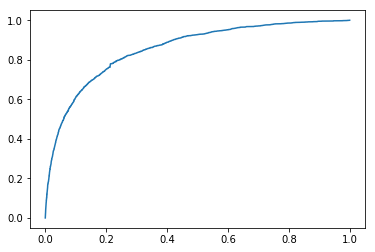

In [56]:
fpr, tpr, thresholds = roc_curve(prediction['SeriousDlqin2yrs'],prediction['1 probability'])
plt.plot(fpr, tpr)

## Error analysis

### Take the 100 biggest errors

In [46]:
prediction['absolute_error']=(prediction['1 probability']-prediction['SeriousDlqin2yrs']).abs()
prediction = prediction.sort_values(by='absolute_error', ascending=False).head(100)

### Confusion matrix

In [77]:
TP_lines = (prediction['SeriousDlqin2yrs']==1) & (prediction['SeriousDlqin2yrs.1']==1)
TN_lines = ~(prediction['SeriousDlqin2yrs']==1) & ~(prediction['SeriousDlqin2yrs.1']==1)
FP_lines = ~(prediction['SeriousDlqin2yrs']==1) & (prediction['SeriousDlqin2yrs.1']==1)
FN_lines = (prediction['SeriousDlqin2yrs']==1) & ~(prediction['SeriousDlqin2yrs.1']==1)

TP = len(prediction.loc[TP_lines])
TN = len(prediction.loc[TN_lines])
FP = len(prediction.loc[FP_lines])
FN = len(prediction.loc[FN_lines])

TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
PPV=TP/(TP+FP)
NPV=TN/(TN+FN)
accuracy=(TP+TN)/(TP+TN+FP+FN)

d = {'P\u0302': [TP, FP, PPV], 'N\u0302': [FN, TN, NPV], 'Recall': [TPR, TNR, accuracy]}
confusion_matrix = DataFrame(data=d,index=['P','N', 'Precision'])
confusion_matrix

,P̂,N̂,Recall
P,361.000000,1720.000000,0.173474
N,251.000000,27668.000000,0.991010
Precision,0.589869,0.941473,0.934300


### Cost optimization

In [58]:
def cost_threshold(threshold):
    prediction_threshold = prediction['1 probability'] > threshold

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    P_real = (prediction['SeriousDlqin2yrs'] == 1)
    N_real = (prediction['SeriousDlqin2yrs'] == 0)

    TP = len(prediction.loc[P_pred & P_real])
    TN = len(prediction.loc[N_pred & N_real])
    FP = len(prediction.loc[P_pred & N_real])
    FN = len(prediction.loc[N_pred & P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

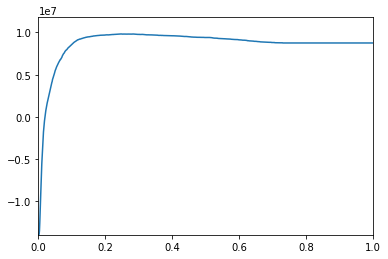

In [59]:
table = [cost_threshold(n/1000) for n in range(0,1000)]
threshold = [n/1000 for n in range(0,1000)]
plt.axis([0, 1,min(table),1.2*max(table)])
plt.plot(threshold, table)
plt.show()

In [60]:
max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est 9825500 et il est obtenu avec un seuil de 0.245


Compute the cost for all thresholds

In [61]:
threshold_list = prediction['1 probability'].sort_values().values
threshold_intervals = []
for i in range(len(threshold_list)-1):
    midpoint=(threshold_list[i]+threshold_list[i+1])/2
    threshold_intervals.append(midpoint)
table = [cost_threshold(t) for t in threshold_intervals]

In [63]:
max_val = max(table)
max_threshold = threshold_intervals[table.index(max_val)]
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est -13959500 et il est obtenu avec un seuil de 0.00133


## AUC computation by hand
### The naive way: fast to implement and slow to run.

Don't mind the limit case.

In [ ]:
TPR=[]
FPR=[]

threshold_list = prediction['1 probability'].sort_values().values

P_real = (prediction['SeriousDlqin2yrs'] == 1)
N_real = (prediction['SeriousDlqin2yrs'] == 0)
nb_P_real=len(prediction.loc[P_real])
nb_N_real=len(prediction.loc[N_real])

for t in threshold_list:
    prediction_threshold = prediction['1 probability'] > t

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    TP = len(prediction.loc[P_pred & P_real])
    FP = len(prediction.loc[P_pred & N_real])

    TPR.append(TP/(nb_P_real))
    FPR.append(FP/(nb_N_real))

AUC=0
for i in range(len(TPR)-1):
    AUC+=(FPR[i]-FPR[i+1])*(TPR[i+1]+TPR[i])/2
print(AUC)

### Computing the auc by hand the pandas way

In [64]:
P_real = (prediction['SeriousDlqin2yrs'] == 1)
N_real = (prediction['SeriousDlqin2yrs'] == 0)
nb_P_real=len(prediction.loc[P_real])
nb_N_real=len(prediction.loc[N_real])

total=len(prediction)

df_threshold=DataFrame(index=prediction['1 probability'])
df_threshold['P_real'] = P_real.values
df_threshold['N_real'] = N_real.values
df_threshold['P']=prediction['SeriousDlqin2yrs'].values
df_threshold.sort_index(inplace=True, ascending=False)

TP_cumsum =  df_threshold['P_real'].cumsum()
TPR_next = TP_cumsum/nb_P_real #TPR right after threshold
TPR_prev = TPR_next.shift(1,fill_value=0) #TPR right before threshold

FP_cumsum =  df_threshold['N_real'].cumsum()
FPR_next = FP_cumsum/nb_N_real #FPR right after threshold
FPR_prev = FPR_next.shift(1,fill_value=0) #FPR right before threshold

auc = ((FPR_next-FPR_prev)*(TPR_prev+TPR_next)/2).sum()

print(f'AUC={auc}')
#df_threshold

AUC=0.8555285533824173


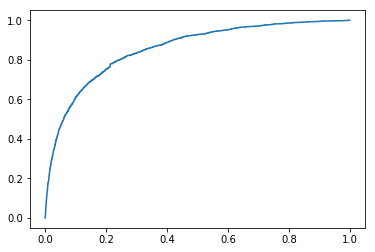

In [65]:
plt.plot(FPR_next,TPR_next)
plt.show()